## Difference-in-Differences

Diff-in-diff это метод, используемый в causal inference, для оценки влияния эффекта во времени. Примерами использования этого метода являются, к примеру, оценка эффекта иммиграции на безработицу, эффекта изменений в законе об оружии на уровень преступности или просто разницы в вовлеченности пользователей в результате маркетинговой кампании. Во всех этих случаях есть период до и после вмешательства, и целью стоит отделение влияния вмешательства от общей тенденции.

Для примера рассмотрим следующую проблему. Чтобы выяснить, насколько хороши рекламные щиты как маркетинговый канал, было размещено 3 рекламных щита на въезде одного из городов.

Для оценки влияния эффекта щитов был также выбран другой город, находящийся неподалеку. Щит был размещен на весь июнь. Посмотрим на имеющиеся данные.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline

style.use("fivethirtyeight")

In [ ]:
data = pd.read_csv("/content/billboard_impact.csv")
data.head()

,Прибыль,Город,После_размещения
0,42,1,0
1,0,1,0
2,52,1,0
3,119,1,0
4,21,1,0


В данной таблице прибыль - это то, что было получено от одного из клиентов. Город==1 соответствует строкам для тестового города, а Город==0 - контрольный город. После_размещения говорит о том, какой период рассматривается - до размещения щитов или после.

Попробуем оценить разницу в средней прибыли до и после размещения щита.

In [ ]:
t_before = data.query("Город==1 & После_размещения==0")["Прибыль"].mean()

t_after = data.query("Город==1 & После_размещения==1")["Прибыль"].mean()

t_after - t_before

41.04775

Получаем, что средняя разница увеличилась на 41 единицу. Но можно ли верить этому результату?

Давайте попробуем оценить разницу в прибыли из разных городов:

In [ ]:
c_after = data.query("Город==0 & После_размещения==1")["Прибыль"].mean()
t_after - c_after

-119.10175000000001

Данный результат говорит что кампания была крайне неуспешной и клиенты начали тратить значительно меньше.

Посчитаем теперь сам diff-in-diff.

In [ ]:
c_before = data.query("Город==0 & После_размещения==0")["Прибыль"].mean()

diff_in_diff = (t_after-t_before)-(c_after-c_before)
diff_in_diff

6.524557692307688

Значение diff-in-diff говорит что мы, на самом деле, уменьшили разницу между городами в лучшую сторону. То есть, на самом деле есть положительный эффект.

Визуализируем его.

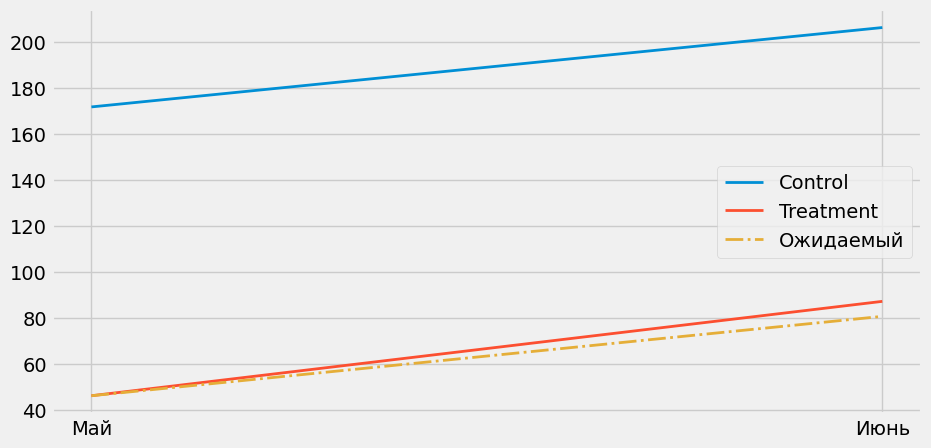

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(["Май", "Июнь"], [c_before, c_after], label="Control", lw=2)
plt.plot(["Май", "Июнь"], [t_before, t_after], label="Treatment", lw=2)

plt.plot(["Май", "Июнь"], [t_before, t_before+(c_after-c_before)],
         label="Ожидаемый Treatment", lw=2, color="C2", ls="-.")

plt.legend();

Вот это маленькое отклонение красной линии от пунктирной и есть найденный эффект.

Однако, проблемой diff-in-diff является детекция параллельных трендов. Если разница между двумя городами постоянно меняется, то нельзя сказать, является ли найденный эффект следствием размещения щитов.

Для примера, разобьем данные на части и будем считать, что часть этих данных пришла в предыдущие месяцы.

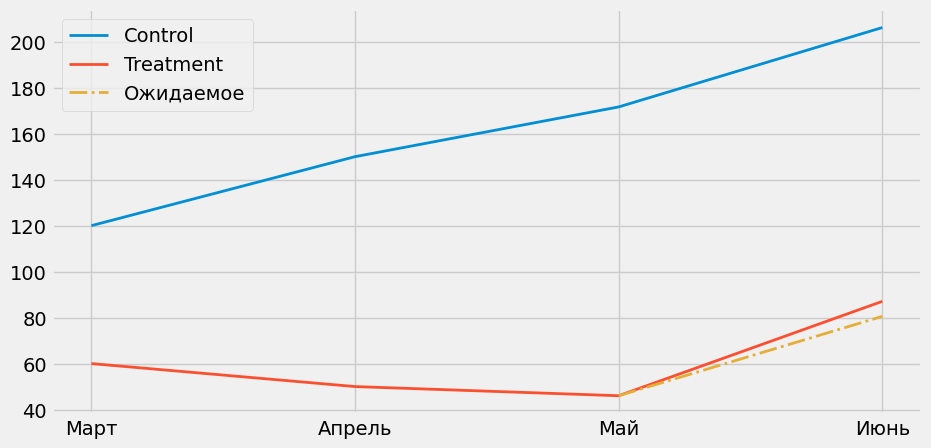

In [ ]:
plt.figure(figsize=(10,5))
x = ["Март", "Апрель", "Май", "Июнь"]

plt.plot(x, [120, 150, c_before,  c_after], label="Control", lw=2)
plt.plot(x, [60, 50, t_before, t_after], label="Treatment", lw=2)

plt.plot(["Май", "Июнь"], [t_before, t_before+(c_after-c_before)], label="Ожидаемое", lw=2, color="C2", ls="-.")

plt.legend();

К сожалению, в случае таких ситуаций требуется использовать синтетический контроль

## Синтетический контроль

В 1988 году Калифорния приняла закон о налоге на табак и защите здоровья «Его основной эффект заключается в том, чтобы ввести государственный акцизный налог в размере 25 центов за пачку на продажу табачных сигарет в Калифорнии, с примерно эквивалентными акцизными налогами, аналогичным образом введенными на розничную продажу других коммерческих табачных изделий, таких как сигары и жевательный табак. Дополнительные ограничения, налагаемые на продажу табака, включают запрет на автоматы по продаже сигарет в общественных местах, доступных для несовершеннолетних, и запрет на индивидуальную продажу отдельных сигарет. Доход, полученный в результате этого закона, был направлен на различные программы по охране окружающей среды и здравоохранения, а также на антитабачную рекламу».

Чтобы оценить его эффект, можно собрать данные о продажах сигарет из нескольких штатов за несколько лет. Загрузим данные с 1970 по 2000 год из 39 штатов. Штаты, в которых были введены похожие методы против курения табака, были исключены из рассмотрения. Вот как выглядят наши данные.

In [ ]:
cigar = (pd.read_csv("/content/smoking.csv")
         .drop(columns=["lnincome","beer", "age15to24"]))

cigar.query("california").head()

,state,year,cigsale,retprice,california,after_treatment
62,3,1970,123.000000,38.799999,True,False
63,3,1971,121.000000,39.700001,True,False
64,3,1972,123.500000,39.900002,True,False
65,3,1973,124.400002,39.900002,True,False
66,3,1974,126.699997,41.900002,True,False


Поле state является индексом штата, где California — это 3. Ковариаты — retprice, розничная цена сигарет, и cigsale, продажи сигарет на душу населения. Интересующая нас переменная — cigsale. Также есть вспомогательные переменные boolean, которые сигнализируют о штате Калифорния и периоде после вмешательства. Если мы построим график продаж сигарет для Калифорнии и других штатов с течением времени, то получим следующее.

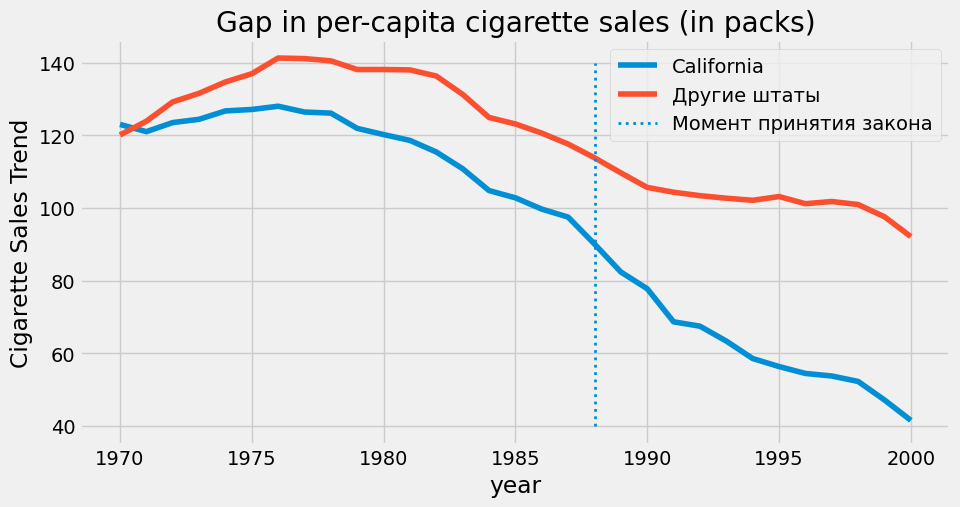

In [ ]:
ax = plt.subplot(1, 1, 1)

(cigar
 .assign(california = np.where(cigar["california"], "California", "Другие штаты"))
 .groupby(["year", "california"])
 ["cigsale"]
 .mean()
 .reset_index()
 .pivot(index="year", columns="california", values="cigsale")
 .plot(ax=ax, figsize=(10,5)))

plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Момент принятия закона")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plt.legend();

В течение времени, за которое у нас есть данные, люди в Калифорнии, по-видимому, покупали меньше сигарет, чем в среднем по стране. Кроме того, похоже, что это глобальный тренд падения курения после 80-х. Однако кажется, что после принятия закона тенденция к снижению в Калифорнии ускорилась по сравнению с другими штатами, но мы не можем сказать этого наверняка. Это всего лишь предположение, которое мы получили, изучив график.

Чтобы ответить на вопрос, повлиял ли закон на потребление сигарет, мы будем использовать период до вмешательства для построения синтетического контроля. Мы объединим другие штаты, чтобы построить фальшивый штат, который очень похож на тенденцию Калифорнии. Затем мы посмотрим, как этот синтетический контроль ведет себя после вмешательства.

Для этого первое, что нам нужно, — это преобразовать единицы (в нашем случае, штаты) в столбцы, а время — в строки. Поскольку у нас есть 2 признака, cigsale и retprice, мы наложим их друг на друга, как на рисунке выше. Мы построим синтетический контроль, который очень похож на Калифорнию в период до вмешательства, и посмотрим, как он будет себя вести в период после вмешательства. Здесь признаки находятся в схожем масштабе, поэтому мы ничего с ними не делаем. Если признаки находятся в разных масштабах, один в тысячах, а другой в десятичных дробях, больший признак будет наиболее важным при минимизации разницы.

In [ ]:
features = ["cigsale", "retprice"]

inverted = (cigar.query("~after_treatment") # filter pre-intervention period
            .pivot(index='state', columns="year")[features] # make one column per year and one row per state
            .T) # flip the table to have one column per state

inverted.head()

state                 1           2           3           4           5   \
        year                                                               
cigsale 1970   89.800003  100.300003  123.000000  124.800003  120.000000   
        1971   95.400002  104.099998  121.000000  125.500000  117.599998   
        1972  101.099998  103.900002  123.500000  134.300003  110.800003   
        1973  102.900002  108.000000  124.400002  137.899994  109.300003   
        1974  108.199997  109.699997  126.699997  132.800003  112.400002   

state                 6           7           8           9           10  ...  \
        year                                                              ...   
cigsale 1970  155.000000  109.900002  102.400002  124.800003  134.600006  ...   
        1971  161.100006  115.699997  108.500000  125.599998  139.300003  ...   
        1972  156.300003  117.000000  126.099998  126.599998  149.199997  ...   
        1973  154.699997  119.800003  121.800003  124.400002  156.000000  ...   
        1974  151.300003  123.699997  125.599998  131.899994  159.600006  ...   

state                 30          31          32          33         34  \
        year                                                              
cigsale 1970  103.599998   92.699997   99.800003  106.400002  65.500000   
        1971  115.000000   96.699997  106.300003  108.900002  67.699997   
        1972  118.699997  103.000000  111.500000  108.599998  71.300003   
        1973  125.500000  103.500000  109.699997  110.400002  72.699997   
        1974  129.699997  108.400002  114.800003  114.699997  75.599998   

state                 35          36          37          38          39  
        year                                                              
cigsale 1970  122.599998  124.300003  114.500000  106.400002  132.199997  
        1971  124.400002  128.399994  111.500000  105.400002  131.699997  
        1972  138.000000  137.000000  117.500000  108.800003  140.000000  
        1973  146.800003  143.100006  116.599998  109.500000  141.199997  
        1974  151.800003  149.600006  119.900002  111.800003  145.800003  

[5 rows x 39 columns]

Теперь мы можем определить нашу переменную Y как штат Калифорния, а X — как остальные штаты.


In [ ]:
y = inverted[3].values # state of california
X = inverted.drop(columns=3).values  # other states

Затем требуется обучить регрессию.

In [ ]:
from sklearn.linear_model import LinearRegression
weights_lr = LinearRegression(fit_intercept=False).fit(X, y).coef_
weights_lr.round(3)

array([-0.436, -1.038,  0.679,  0.078,  0.339,  1.213,  0.143,  0.555,
       -0.295,  0.052, -0.529,  1.235, -0.549,  0.437, -0.023, -0.266,
       -0.25 , -0.667, -0.106, -0.145,  0.109,  0.242, -0.328,  0.594,
        0.243, -0.171, -0.02 ,  0.14 , -0.811,  0.362,  0.519, -0.304,
        0.805, -0.318, -1.246,  0.773, -0.055, -0.032])

Эти веса показывают, как построить синтетический контроль. Умножив результат состояния 1 на -0,436, состояния 2 на -1,038, состояния 4 на 0,679 и т. д..

In [ ]:
calif_synth_lr = (cigar.query("~california")
                  .pivot(index='year', columns="state")["cigsale"]
                  .values.dot(weights_lr))

Теперь, когда у нас есть синтетический контроль, мы можем построить его на основе выходной переменной штата Калифорния.

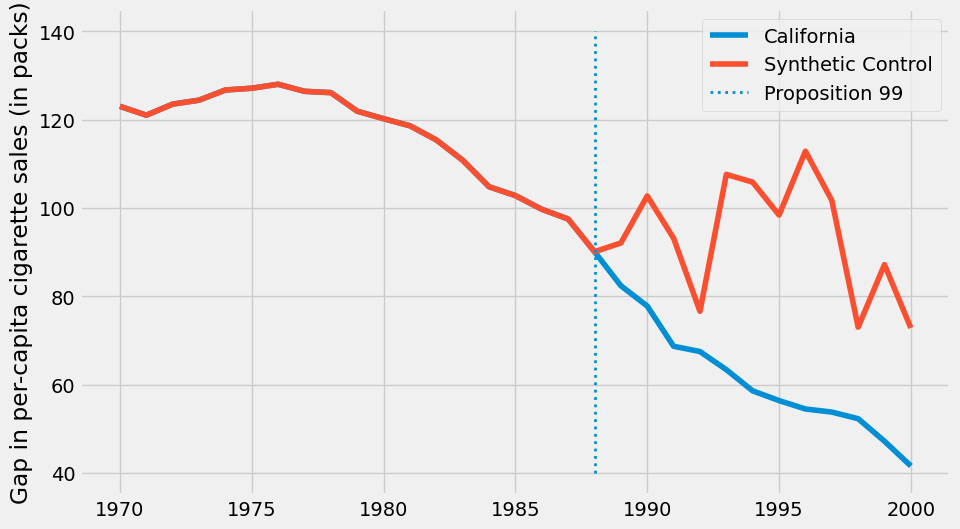

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth_lr, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

Хорошо... Что-то пошло не так. Что привлекает внимание на этой картинке? Во-первых, после вмешательства синтетический контроль продает больше сигарет, чем Калифорния. Во-вторых как идеально подобран период до вмешательства. Синтетический контроль способен точно соответствовать штату Калифорния. Это признак того, что наша модель синтетического контроля, вероятно, переобучилась. Другим признаком является огромная дисперсия выходной переменной синтетического контроля после вмешательства, т.к. она идет вверх и вниз, вверх и вниз.

Основная причина проблемы в том, что нам нужна экстраполяция, а не интерполяция. Применим это:

In [ ]:
from typing import List
from operator import add
from toolz import reduce, partial

def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

lambda x: np.sum(x) - 1

from scipy.optimize import fmin_slsqp

def get_w(X, y):

    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights

calif_weights = get_w(X, y)
print("Sum:", calif_weights.sum())
np.round(calif_weights, 4)

Sum: 1.000000000000424


array([0.    , 0.    , 0.    , 0.0852, 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.113 , 0.1051, 0.4566, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.2401, 0.    , 0.    , 0.    , 0.    , 0.    ])

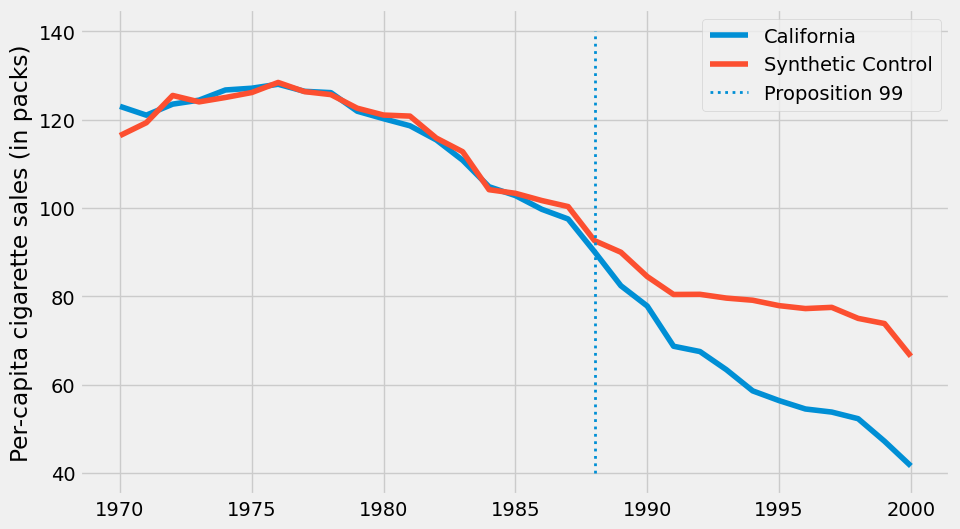

In [ ]:
calif_synth = cigar.query("~california").pivot(index='year', columns="state")["cigsale"].values.dot(calif_weights)


plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"], label="California")
plt.plot(cigar.query("california")["year"], calif_synth, label="Synthetic Control")
plt.vlines(x=1988, ymin=40, ymax=140, linestyle=":", lw=2, label="Proposition 99")
plt.ylabel("Per-capita cigarette sales (in packs)")
plt.legend();

Теперь, имея более качественный синтетический контроль, найдем разницу:

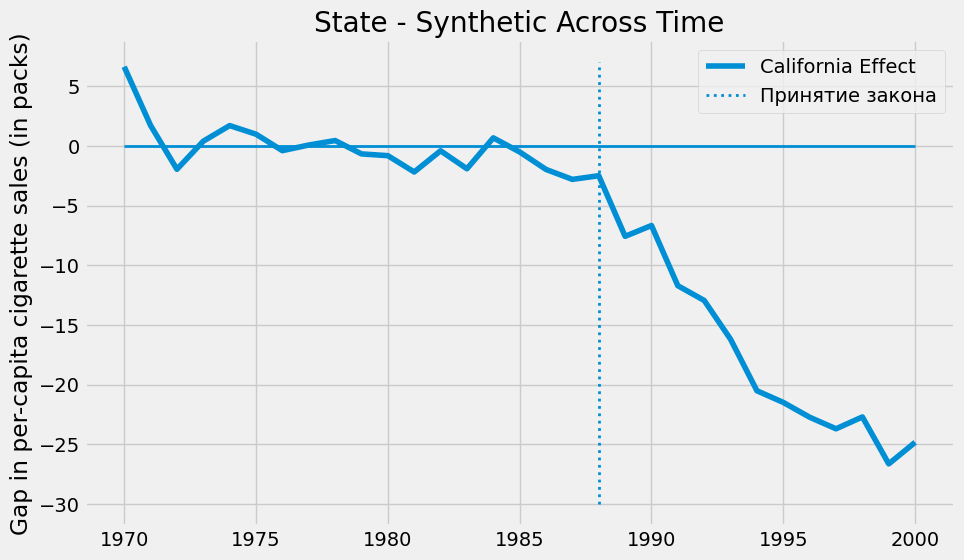

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(cigar.query("california")["year"], cigar.query("california")["cigsale"] - calif_synth,
         label="California Effect")
plt.vlines(x=1988, ymin=-30, ymax=7, linestyle=":", lw=2, label="Принятие закона")
plt.hlines(y=0, xmin=1970, xmax=2000, lw=2)
plt.title("State - Synthetic Across Time")
plt.ylabel("Gap in per-capita cigarette sales (in packs)")
plt.legend();

## Regression Discontinuity Design

Попробуем ответить на очень важный вопрос - как алкоголь влияет на смертность. Выдвигаем предположение - с возраста, с которого официально разрешено употреблять алкоголь, мы должны увидеть (или не увидеть) скачок смертности. Предположим, что те, кому чуть меньше 21 года, не пьют (или пьют намного меньше), а те, кому чуть больше 21 года, пьют. Это означает, что вероятность употребления алкоголя резко возрастает в 21 год, и это то, что мы можем исследовать с помощью RDD.

Для этого исследуем данные о смертности, агрегированные по возрасту. Каждая строка — это средний возраст группы людей и средняя смертность по всем причинам (all), по дорожно-транспортным происшествиям (mva) и по самоубийствам (suicide).

In [ ]:
drinking = pd.read_csv("/content/drinking.csv")
drinking.head()[["agecell", "all", "mva", "suicide"]]

,agecell,all,mva,suicide
0,19.068493,92.825400,35.829327,11.203714
1,19.150684,95.100740,35.639256,12.193368
2,19.232876,92.144295,34.205650,11.715812
3,19.315070,88.427760,32.278957,11.275010
4,19.397260,88.704940,32.650967,10.984314


Для наглядности центрируем возраст на значении 21 года.

In [ ]:
drinking["agecell"] -= 21

Попробуем визуально оценить уровень смертности по каждой из причин.

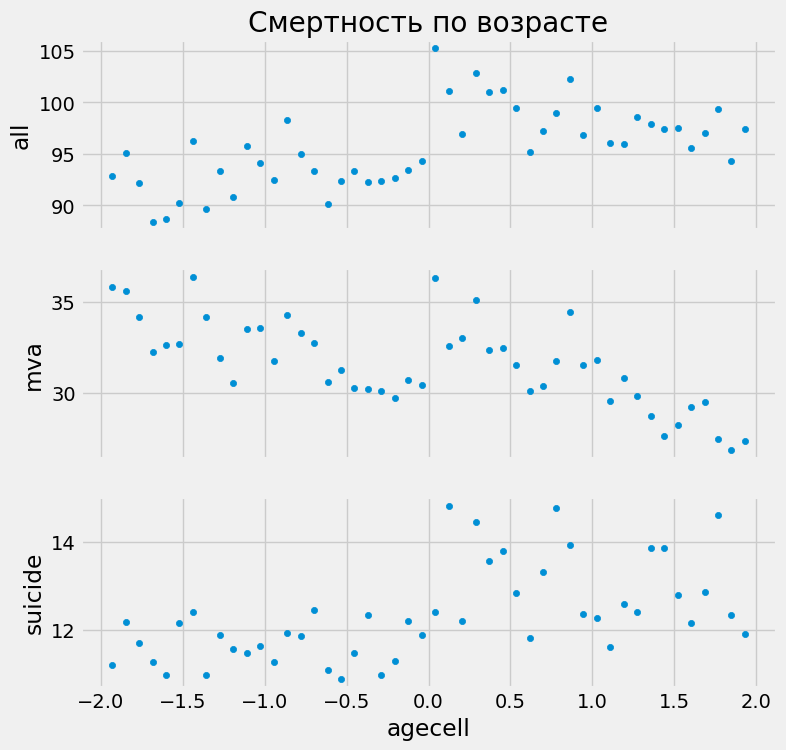

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.subplot(3,1,1)
drinking.plot.scatter(x="agecell", y="all", ax=ax)
plt.title("Смертность по возрасту")

ax = plt.subplot(3,1,2, sharex=ax)
drinking.plot.scatter(x="agecell", y="mva", ax=ax)

ax = plt.subplot(3,1,3, sharex=ax)
drinking.plot.scatter(x="agecell", y="suicide", ax=ax);

Картина начинает проясняться, но этого еще недостаточно. Каково именно влияние употребления алкоголя на смертность на пороге? И какова стандартная ошибка этой оценки?

Построим линейную регрессию и посмотрим на неё в районе нашего порога.

In [ ]:
rdd_df = drinking.assign(threshold=(drinking["agecell"] > 0).astype(int))

model = smf.wls("all~agecell*threshold", rdd_df).fit()

model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,93.6184,0.932,100.399,0.000,91.739,95.498
agecell,0.8270,0.819,1.010,0.318,-0.823,2.477
threshold,7.6627,1.319,5.811,0.000,5.005,10.320
agecell:threshold,-3.6034,1.158,-3.111,0.003,-5.937,-1.269


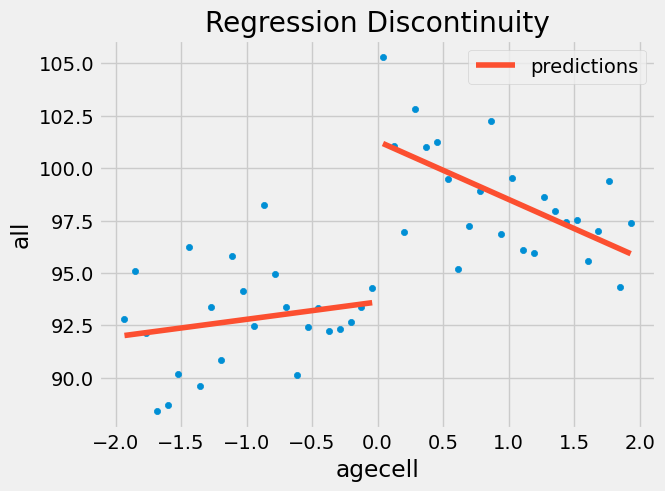

In [ ]:
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity");

И то же самое для других причин смерти:

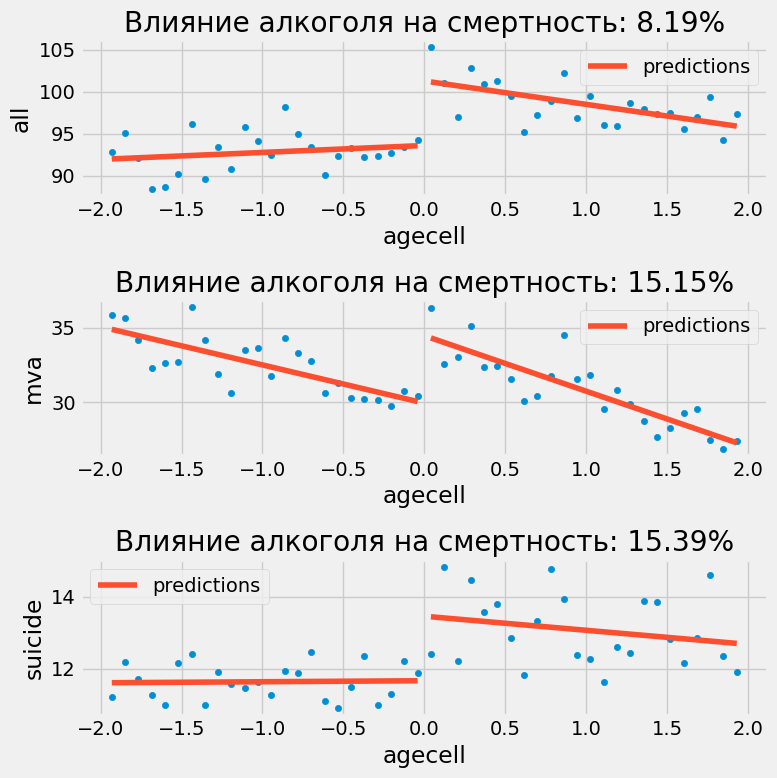

In [ ]:
plt.figure(figsize=(8,8))

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Влияние алкоголя на смертность: {np.round(ate_pct, 2)}%")

plt.tight_layout()

RDD сообщает нам, что алкоголь увеличивает вероятность смерти на 15%, что является довольно значительной величиной. Эти результаты являются убедительными аргументами в пользу того, чтобы не снижать возраст, с которого разрешено употребление алкоголя, если мы хотим минимизировать уровень смертности.

Попробуем также воспользоваться ядерным подходом.

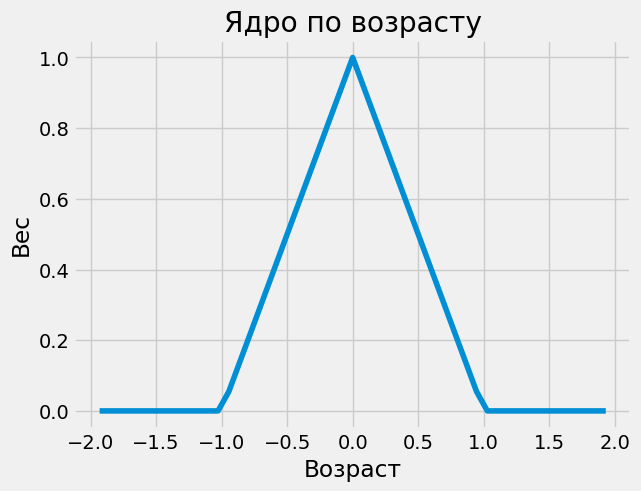

In [ ]:
def kernel(R, c, h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)

plt.plot(drinking["agecell"], kernel(drinking["agecell"], c=0, h=1))
plt.xlabel("Возраст")
plt.ylabel("Вес")
plt.title("Ядро по возрасту");

Посмотрим, как будут отличаться результаты при использовании ядра:

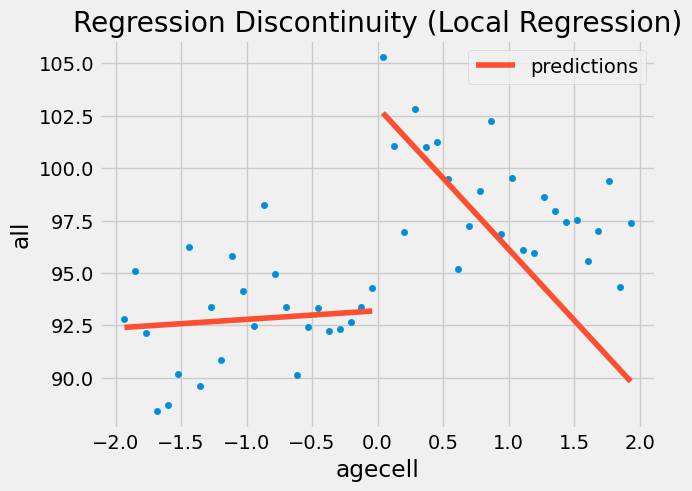

In [ ]:
model = smf.wls("all~agecell*threshold", rdd_df,
                weights=kernel(drinking["agecell"], c=0, h=1)).fit()

model.summary().tables[1]
ax = drinking.plot.scatter(x="agecell", y="all", color="C0")
drinking.assign(predictions=model.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
plt.title("Regression Discontinuity (Local Regression)");

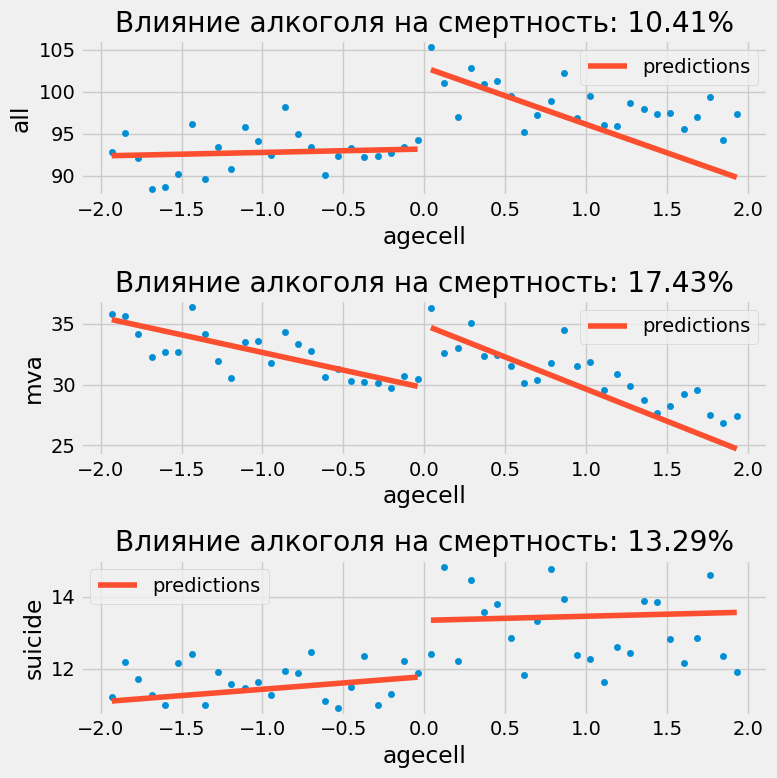

In [ ]:
plt.figure(figsize=(8,8))
weights = kernel(drinking["agecell"], c=0, h=1)

for p, cause in enumerate(["all", "mva", "suicide"], 1):
    ax = plt.subplot(3,1,p)
    drinking.plot.scatter(x="agecell", y=cause, ax=ax)
    m = smf.wls(f"{cause}~agecell*threshold", rdd_df, weights=weights).fit()
    ate_pct = 100*((m.params["threshold"] + m.params["Intercept"])/m.params["Intercept"] - 1)
    drinking.assign(predictions=m.fittedvalues).plot(x="agecell", y="predictions", ax=ax, color="C1")
    plt.title(f"Влияние алкоголя на смертность: {np.round(ate_pct, 2)}%")

plt.tight_layout()

За исключением самоубийств, похоже, что добавление ядра увеличило негативное влияние алкоголя. То есть, если мы хотим минимизировать уровень смертности, мы НЕ должны рекомендовать снижение возраста, с которого разрешено употребление алкоголя, поскольку существует явное влияние алкоголя на уровень смертности.